In [1]:
import os 
import pytorch_lightning as pl
import seml
from paths import DATA_DIR, CKPT_FOLDER
import numpy as np
from tqdm import tqdm
import torch

from sacred import SETTINGS, Experiment
from functools import partial

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from torchdyn.core import NeuralODE

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.base.vae import VAE, AE
from scCFM.models.cfm.cfm_module import CFMLitModule
 
from conditional_flow_matching import *

from torch.optim import AdamW

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

from conditional_flow_matching import *

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
from typing import List, Optional

import torch
from torch import nn

ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "selu": nn.SELU,
    "elu": nn.ELU,
    "lrelu": nn.LeakyReLU,
    "softplus": nn.Softplus,
}


class SimpleDenseNet(nn.Module):
    def __init__(
        self,
        input_size: int,
        target_size: int,
        activation: str,
        batch_norm: bool = True,
        hidden_dims: Optional[List[int]] = None,
    ):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [64, 64, 64]
        dims = [input_size, *hidden_dims, target_size]
        layers = []
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(dims[i + 1]))
            layers.append(ACTIVATION_MAP[activation]())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class TimeInvariantVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        del t
        return self.model(x)


class VelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, x):
        """ignore t run model."""
        return self.model(x)

Read anndata 

In [3]:
adata_latent = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")

In [4]:
adata_latent.obs["experimental_time"].to_numpy()

array([0.25, 0.75, 1.  , ..., 0.  , 0.25, 0.25])

In [5]:
module = TrajectoryDataModule(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad",
                            "X_latents",
                            "experimental_time", 
                            use_pca=False, 
                            n_dimensions=None, 
                            model_library_size=True)

## Import configurations

In [17]:
with open("/nfs/homedirs/pala/scCFM/configs/ae/eb/config.yaml", "r") as stream:
    hparams_ae = yaml.safe_load(stream)["fixed"]

In [57]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))

## Initialize and train/load autoencoder 

In [5]:
pretrained_ae = True
pretrained_ckpt_ae = "/nfs/students/pala/scCFM/experiments/ae/eb_vae/checkpoints/epoch_0033.ckpt"

In [6]:
task_name = hparams_ae["training.training"]["task_name"]
        
# Fix seed for reproducibility
torch.manual_seed(hparams_ae["training.training"]["seed"])      
if hparams_ae["training.training"]["seed"]: 
    pl.seed_everything(hparams_ae["training.training"]["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / "ae" / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 
    

# Initialize datamodule
datamodule = scDataModule(**hparams_ae["datamodule.datamodule"])


# Initialize the model 
ae_model = VAE(in_dim = datamodule.dim,
            **hparams_ae["model.model"]
            ) 
        
if not pretrained_ae:
    # Initialize callbacks 
    model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                            **hparams_ae["model_checkpoint.model_checkpoint"])


    # Initialize callbacks 
    early_stopping_callbacks = EarlyStopping(**hparams_ae["early_stopping.early_stopping"])


    # Initialize logger 
    logger = WandbLogger(save_dir=current_experiment_dir / "logs", 
                         **hparams_ae["logger.logger"]) 


    # Initialize the lightning trainer 
    trainer = Trainer(default_root_dir=current_experiment_dir,
                      callbacks=[model_ckpt_callbacks, early_stopping_callbacks], 
                      logger=logger, 
                      **hparams_ae["trainer.trainer"])


    # # Fit the model 
    trainer.fit(model=ae_model, 
                      train_dataloaders=datamodule.train_dataloader(),
                      val_dataloaders=datamodule.val_dataloader())
    train_metrics = trainer.callback_metrics

else:
    ae_model.load_state_dict(torch.load(pretrained_ckpt_ae)["state_dict"])

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


**Analyze autoencoder latent space**

In [7]:
# z_cells = []
# annot = []
# with torch.no_grad():
#     for batch in datamodule.train_dataloader():
#         annot.append(batch["cond"])
#         mu = ae_model.encode(torch.log(1 + batch["X"]))["z"]
#         z_cells.append(mu)

# z_cells= torch.cat(z_cells, dim=0)
# annot = pd.DataFrame(torch.cat(annot).numpy())
# annot.columns = ["experimental_time"]

# adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
#                   obs=annot)

In [8]:
z_cells = []
annot = []
ae_model.eval()
with torch.no_grad():
    for cell, cond in zip(adata.X.A, adata.obs.experimental_time):
        annot.append(cond)
        X = torch.from_numpy(cell).unsqueeze(0).float()
        mu = ae_model.encode(torch.log(1 + X))["z"]
        z_cells.append(mu)

z_cells= torch.cat(z_cells, dim=0)
annot = pd.DataFrame(annot)
annot.columns = ["experimental_time"]

adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.tl.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

## Perform CFM training like in the notebook

In [58]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

First we standardize the coordinates

In [59]:
times = sorted(adata_latent.obs["experimental_time"].unique())
n_times = len(times)
# Standardize coordinates
coords = adata_latent.X
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
# adata_latent.layers["X_standardized"] = coords
adata_latent.layers["X_standardized"] = adata_latent.X.copy()
X = [
    adata_latent.layers["X_standardized"][adata_latent.obs["experimental_time"] == t]
    for t in times
]

In [60]:
# ae_model = ae_model.cuda()
# times = sorted(adata.obs["experimental_time"].unique())
# n_times = len(times)
# X = [
#     adata.X.A[adata.obs["experimental_time"] == t]
#     for t in times
# ]

In [61]:
# Shape of the time batches
[i.shape for i in X]

[(2613, 10), (4317, 10), (3585, 10), (3812, 10), (3593, 10)]

In [123]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim=10
model = MLP(dim=dim, time_varying=True, w=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

Batch collecting function

In [124]:
def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

Train OT cfm

In [125]:
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    if i % 20 == 0:
        print(loss.item())
    optimizer.step()

  0%|          | 4/10000 [00:00<10:37, 15.68it/s]

4.475273609161377


  0%|          | 24/10000 [00:01<08:40, 19.18it/s]

4.46051549911499


  0%|          | 43/10000 [00:02<08:36, 19.27it/s]

4.034554958343506


  1%|          | 63/10000 [00:03<08:32, 19.38it/s]

3.89096999168396


  1%|          | 83/10000 [00:04<09:15, 17.87it/s]

3.8741612434387207


  1%|          | 103/10000 [00:05<08:27, 19.50it/s]

3.5039849281311035


  1%|          | 123/10000 [00:06<08:27, 19.46it/s]

3.536900281906128


  1%|▏         | 144/10000 [00:07<08:23, 19.56it/s]

3.2617623805999756


  2%|▏         | 163/10000 [00:08<08:26, 19.43it/s]

2.977973699569702


  2%|▏         | 183/10000 [00:09<08:24, 19.46it/s]

2.9384853839874268


  2%|▏         | 204/10000 [00:10<08:27, 19.29it/s]

2.8602700233459473


  2%|▏         | 223/10000 [00:11<08:21, 19.51it/s]

2.89292049407959


  2%|▏         | 243/10000 [00:12<09:06, 17.84it/s]

2.816258668899536


  3%|▎         | 264/10000 [00:13<08:17, 19.57it/s]

2.8856022357940674


  3%|▎         | 282/10000 [00:14<08:19, 19.47it/s]

2.9207942485809326


  3%|▎         | 303/10000 [00:15<08:15, 19.56it/s]

2.7643933296203613


  3%|▎         | 324/10000 [00:16<08:20, 19.35it/s]

2.5926172733306885


  3%|▎         | 344/10000 [00:17<08:19, 19.34it/s]

2.8486435413360596


  4%|▎         | 364/10000 [00:18<08:16, 19.40it/s]

2.5363595485687256


  4%|▍         | 383/10000 [00:19<08:17, 19.34it/s]

2.559291124343872


  4%|▍         | 404/10000 [00:21<08:10, 19.58it/s]

2.5416932106018066


  4%|▍         | 424/10000 [00:22<08:08, 19.62it/s]

2.588463306427002


  4%|▍         | 443/10000 [00:23<08:10, 19.50it/s]

2.6653566360473633


  5%|▍         | 463/10000 [00:24<08:07, 19.55it/s]

2.5499520301818848


  5%|▍         | 484/10000 [00:25<08:12, 19.32it/s]

2.826268434524536


  5%|▌         | 504/10000 [00:26<08:07, 19.49it/s]

2.7084364891052246


  5%|▌         | 523/10000 [00:27<08:06, 19.49it/s]

2.418442487716675


  5%|▌         | 544/10000 [00:28<08:04, 19.52it/s]

2.450129747390747


  6%|▌         | 564/10000 [00:29<08:58, 17.54it/s]

2.4094178676605225


  6%|▌         | 583/10000 [00:30<08:09, 19.23it/s]

2.4339287281036377


  6%|▌         | 604/10000 [00:31<08:03, 19.44it/s]

2.5413341522216797


  6%|▌         | 623/10000 [00:32<08:02, 19.45it/s]

2.421400785446167


  6%|▋         | 643/10000 [00:33<09:19, 16.72it/s]

2.4513039588928223


  7%|▋         | 663/10000 [00:34<08:02, 19.34it/s]

2.3238818645477295


  7%|▋         | 684/10000 [00:35<07:48, 19.89it/s]

2.3068110942840576


  7%|▋         | 703/10000 [00:36<07:50, 19.76it/s]

2.3082714080810547


  7%|▋         | 723/10000 [00:37<08:01, 19.25it/s]

2.3679425716400146


  7%|▋         | 743/10000 [00:38<08:13, 18.77it/s]

2.5240821838378906


  8%|▊         | 764/10000 [00:39<07:57, 19.35it/s]

2.466254711151123


  8%|▊         | 784/10000 [00:40<07:56, 19.32it/s]

2.3802173137664795


  8%|▊         | 803/10000 [00:41<07:49, 19.59it/s]

2.2850990295410156


  8%|▊         | 824/10000 [00:42<07:50, 19.50it/s]

2.3348701000213623


  8%|▊         | 842/10000 [00:43<07:51, 19.40it/s]

2.5286521911621094


  9%|▊         | 863/10000 [00:44<07:48, 19.49it/s]

2.4486546516418457


  9%|▉         | 883/10000 [00:45<07:46, 19.55it/s]

2.3069417476654053


  9%|▉         | 903/10000 [00:46<07:44, 19.58it/s]

2.314948320388794


  9%|▉         | 923/10000 [00:47<07:46, 19.47it/s]

2.3794515132904053


  9%|▉         | 943/10000 [00:48<07:47, 19.36it/s]

2.392969846725464


 10%|▉         | 962/10000 [00:49<07:46, 19.39it/s]

2.115792989730835


 10%|▉         | 983/10000 [00:50<07:40, 19.60it/s]

2.409548282623291


 10%|█         | 1004/10000 [00:51<07:42, 19.45it/s]

2.222151041030884


 10%|█         | 1024/10000 [00:53<07:43, 19.35it/s]

2.218327760696411


 10%|█         | 1044/10000 [00:54<07:39, 19.49it/s]

2.1089675426483154


 11%|█         | 1063/10000 [00:55<07:42, 19.30it/s]

2.2127389907836914


 11%|█         | 1083/10000 [00:56<07:36, 19.52it/s]

2.3007571697235107


 11%|█         | 1104/10000 [00:57<07:32, 19.64it/s]

2.2899396419525146


 11%|█         | 1123/10000 [00:58<07:31, 19.64it/s]

2.3247756958007812


 11%|█▏        | 1143/10000 [00:59<07:37, 19.37it/s]

2.593393087387085


 12%|█▏        | 1164/10000 [01:00<07:34, 19.42it/s]

2.1497066020965576


 12%|█▏        | 1184/10000 [01:01<07:33, 19.42it/s]

2.3058667182922363


 12%|█▏        | 1203/10000 [01:02<07:35, 19.31it/s]

2.206801652908325


 12%|█▏        | 1225/10000 [01:03<07:29, 19.51it/s]

2.274127721786499


 12%|█▏        | 1243/10000 [01:04<07:28, 19.51it/s]

2.1730644702911377


 13%|█▎        | 1264/10000 [01:05<07:26, 19.56it/s]

2.1789841651916504


 13%|█▎        | 1284/10000 [01:06<07:27, 19.47it/s]

2.0585198402404785


 13%|█▎        | 1303/10000 [01:07<07:31, 19.28it/s]

2.1078264713287354


 13%|█▎        | 1324/10000 [01:08<07:24, 19.52it/s]

2.1734378337860107


 13%|█▎        | 1345/10000 [01:09<07:20, 19.67it/s]

2.2727155685424805


 14%|█▎        | 1363/10000 [01:10<07:19, 19.66it/s]

2.1328694820404053


 14%|█▍        | 1384/10000 [01:11<07:20, 19.56it/s]

2.280423402786255


 14%|█▍        | 1404/10000 [01:12<07:22, 19.42it/s]

2.2898025512695312


 14%|█▍        | 1424/10000 [01:13<07:25, 19.26it/s]

2.1068825721740723


 14%|█▍        | 1444/10000 [01:14<07:22, 19.34it/s]

2.283402681350708


 15%|█▍        | 1462/10000 [01:15<07:22, 19.30it/s]

2.287770986557007


 15%|█▍        | 1483/10000 [01:16<07:17, 19.45it/s]

2.108466386795044


 15%|█▌        | 1504/10000 [01:17<07:13, 19.60it/s]

2.2046496868133545


 15%|█▌        | 1524/10000 [01:18<07:14, 19.51it/s]

2.1127779483795166


 15%|█▌        | 1544/10000 [01:19<07:17, 19.33it/s]

2.1379201412200928


 16%|█▌        | 1564/10000 [01:20<07:23, 19.00it/s]

2.063303232192993


 16%|█▌        | 1582/10000 [01:21<07:11, 19.50it/s]

2.0478174686431885


 16%|█▌        | 1603/10000 [01:22<07:10, 19.53it/s]

2.1071932315826416


 16%|█▌        | 1623/10000 [01:23<07:11, 19.43it/s]

2.3068249225616455


 16%|█▋        | 1643/10000 [01:24<07:11, 19.36it/s]

2.1622676849365234


 17%|█▋        | 1664/10000 [01:25<07:08, 19.44it/s]

1.9902161359786987


 17%|█▋        | 1683/10000 [01:26<07:09, 19.38it/s]

2.0516726970672607


 17%|█▋        | 1703/10000 [01:28<07:03, 19.60it/s]

1.897343635559082


 17%|█▋        | 1723/10000 [01:29<07:02, 19.58it/s]

2.3061561584472656


 17%|█▋        | 1744/10000 [01:30<06:59, 19.69it/s]

2.0630340576171875


 18%|█▊        | 1764/10000 [01:31<07:04, 19.42it/s]

2.0293240547180176


 18%|█▊        | 1783/10000 [01:32<06:56, 19.72it/s]

2.0410256385803223


 18%|█▊        | 1803/10000 [01:33<07:38, 17.87it/s]

1.9725277423858643


 18%|█▊        | 1824/10000 [01:34<06:59, 19.47it/s]

2.1577470302581787


 18%|█▊        | 1843/10000 [01:35<06:55, 19.63it/s]

2.149574041366577


 19%|█▊        | 1863/10000 [01:36<06:59, 19.39it/s]

2.1164400577545166


 19%|█▉        | 1883/10000 [01:37<06:58, 19.38it/s]

2.005286931991577


 19%|█▉        | 1903/10000 [01:38<06:57, 19.38it/s]

2.1562490463256836


 19%|█▉        | 1924/10000 [01:39<06:59, 19.26it/s]

1.9914181232452393


 19%|█▉        | 1944/10000 [01:40<07:22, 18.20it/s]

2.0149168968200684


 20%|█▉        | 1964/10000 [01:41<06:52, 19.47it/s]

2.0507874488830566


 20%|█▉        | 1983/10000 [01:42<06:50, 19.55it/s]

1.9243944883346558


 20%|██        | 2004/10000 [01:43<06:49, 19.54it/s]

2.1005895137786865


 20%|██        | 2023/10000 [01:44<07:10, 18.55it/s]

2.0460422039031982


 20%|██        | 2043/10000 [01:45<06:49, 19.43it/s]

2.125972032546997


 21%|██        | 2063/10000 [01:46<06:49, 19.38it/s]

2.007917881011963


 21%|██        | 2084/10000 [01:47<06:46, 19.49it/s]

2.0938022136688232


 21%|██        | 2105/10000 [01:48<06:44, 19.54it/s]

2.160641670227051


 21%|██        | 2124/10000 [01:49<06:45, 19.42it/s]

2.03629207611084


 21%|██▏       | 2143/10000 [01:50<06:41, 19.58it/s]

1.9255669116973877


 22%|██▏       | 2163/10000 [01:51<06:44, 19.38it/s]

2.0774571895599365


 22%|██▏       | 2183/10000 [01:52<06:44, 19.32it/s]

2.0125229358673096


 22%|██▏       | 2203/10000 [01:54<06:58, 18.61it/s]

2.00459623336792


 22%|██▏       | 2223/10000 [01:55<06:38, 19.54it/s]

2.0486035346984863


 22%|██▏       | 2244/10000 [01:56<06:39, 19.41it/s]

1.949781060218811


 23%|██▎       | 2264/10000 [01:57<06:43, 19.16it/s]

1.9751523733139038


 23%|██▎       | 2284/10000 [01:58<06:35, 19.50it/s]

2.002673387527466


 23%|██▎       | 2303/10000 [01:59<06:34, 19.50it/s]

1.9846935272216797


 23%|██▎       | 2324/10000 [02:00<06:28, 19.75it/s]

1.921241044998169


 23%|██▎       | 2344/10000 [02:01<06:31, 19.56it/s]

1.893951416015625


 24%|██▎       | 2364/10000 [02:02<06:32, 19.43it/s]

2.0875370502471924


 24%|██▍       | 2383/10000 [02:03<06:30, 19.49it/s]

1.8940054178237915


 24%|██▍       | 2404/10000 [02:04<06:31, 19.40it/s]

2.02416729927063


 24%|██▍       | 2424/10000 [02:05<06:29, 19.46it/s]

2.0318799018859863


 24%|██▍       | 2444/10000 [02:06<06:28, 19.47it/s]

1.939116358757019


 25%|██▍       | 2464/10000 [02:07<06:27, 19.43it/s]

1.9164183139801025


 25%|██▍       | 2484/10000 [02:08<06:27, 19.39it/s]

1.943036437034607


 25%|██▌       | 2503/10000 [02:09<06:27, 19.35it/s]

1.8662950992584229


 25%|██▌       | 2523/10000 [02:10<06:27, 19.32it/s]

2.0408501625061035


 25%|██▌       | 2544/10000 [02:11<06:23, 19.44it/s]

2.1124966144561768


 26%|██▌       | 2564/10000 [02:12<06:20, 19.54it/s]

1.9311589002609253


 26%|██▌       | 2584/10000 [02:13<06:21, 19.42it/s]

1.8784061670303345


 26%|██▌       | 2604/10000 [02:14<06:24, 19.24it/s]

2.0184316635131836


 26%|██▌       | 2624/10000 [02:15<06:22, 19.29it/s]

2.1612281799316406


 26%|██▋       | 2644/10000 [02:16<06:20, 19.34it/s]

1.9484474658966064


 27%|██▋       | 2663/10000 [02:17<06:16, 19.49it/s]

2.0103533267974854


 27%|██▋       | 2685/10000 [02:18<06:13, 19.59it/s]

1.9042482376098633


 27%|██▋       | 2703/10000 [02:19<06:15, 19.43it/s]

1.929164171218872


 27%|██▋       | 2723/10000 [02:20<06:12, 19.54it/s]

1.9175819158554077


 27%|██▋       | 2744/10000 [02:21<06:17, 19.24it/s]

1.906754493713379


 28%|██▊       | 2763/10000 [02:22<06:11, 19.46it/s]

1.9129304885864258


 28%|██▊       | 2784/10000 [02:23<06:08, 19.58it/s]

2.045562505722046


 28%|██▊       | 2803/10000 [02:24<06:06, 19.64it/s]

1.9007256031036377


 28%|██▊       | 2823/10000 [02:26<06:11, 19.34it/s]

1.9191910028457642


 28%|██▊       | 2843/10000 [02:27<06:06, 19.55it/s]

1.9944473505020142


 29%|██▊       | 2864/10000 [02:28<06:41, 17.79it/s]

1.8278400897979736


 29%|██▉       | 2882/10000 [02:29<06:08, 19.30it/s]

1.8765652179718018


 29%|██▉       | 2903/10000 [02:30<06:03, 19.51it/s]

1.9418543577194214


 29%|██▉       | 2924/10000 [02:31<06:11, 19.05it/s]

1.764988899230957


 29%|██▉       | 2944/10000 [02:32<06:13, 18.90it/s]

2.0060529708862305


 30%|██▉       | 2964/10000 [02:33<06:08, 19.09it/s]

1.9052437543869019


 30%|██▉       | 2984/10000 [02:34<06:06, 19.14it/s]

1.8620563745498657


 30%|███       | 3004/10000 [02:35<06:08, 18.97it/s]

1.9728916883468628


 30%|███       | 3024/10000 [02:36<06:09, 18.90it/s]

1.8992732763290405


 30%|███       | 3044/10000 [02:37<06:03, 19.14it/s]

1.838004469871521


 31%|███       | 3064/10000 [02:38<06:03, 19.10it/s]

2.0105597972869873


 31%|███       | 3084/10000 [02:39<06:00, 19.17it/s]

1.977678656578064


 31%|███       | 3104/10000 [02:40<06:03, 18.97it/s]

2.035332441329956


 31%|███       | 3124/10000 [02:41<06:02, 18.99it/s]

1.9092895984649658


 31%|███▏      | 3144/10000 [02:42<06:00, 19.03it/s]

2.011324644088745


 32%|███▏      | 3164/10000 [02:44<06:24, 17.76it/s]

2.119920492172241


 32%|███▏      | 3184/10000 [02:45<06:02, 18.83it/s]

1.9327219724655151


 32%|███▏      | 3204/10000 [02:46<05:58, 18.95it/s]

2.005181074142456


 32%|███▏      | 3224/10000 [02:47<05:56, 19.00it/s]

2.001619338989258


 32%|███▏      | 3244/10000 [02:48<05:59, 18.80it/s]

2.0045406818389893


 33%|███▎      | 3264/10000 [02:49<05:57, 18.82it/s]

2.0043482780456543


 33%|███▎      | 3284/10000 [02:50<05:55, 18.91it/s]

1.869796633720398


 33%|███▎      | 3303/10000 [02:51<05:41, 19.58it/s]

1.9188686609268188


 33%|███▎      | 3323/10000 [02:52<05:40, 19.60it/s]

2.0516107082366943


 33%|███▎      | 3344/10000 [02:53<05:44, 19.35it/s]

1.9239472150802612


 34%|███▎      | 3364/10000 [02:54<05:41, 19.45it/s]

1.8299951553344727


 34%|███▍      | 3384/10000 [02:55<05:38, 19.55it/s]

1.927212119102478


 34%|███▍      | 3404/10000 [02:56<05:37, 19.55it/s]

2.067188024520874


 34%|███▍      | 3423/10000 [02:57<05:34, 19.66it/s]

2.009295701980591


 34%|███▍      | 3443/10000 [02:58<05:34, 19.60it/s]

1.8925342559814453


 35%|███▍      | 3463/10000 [02:59<05:35, 19.48it/s]

1.8683750629425049


 35%|███▍      | 3483/10000 [03:00<05:38, 19.26it/s]

1.9475154876708984


 35%|███▌      | 3503/10000 [03:01<05:35, 19.35it/s]

1.986871600151062


 35%|███▌      | 3523/10000 [03:02<05:34, 19.37it/s]

2.029780864715576


 35%|███▌      | 3544/10000 [03:03<05:30, 19.52it/s]

1.8265167474746704


 36%|███▌      | 3563/10000 [03:04<05:29, 19.54it/s]

1.8944038152694702


 36%|███▌      | 3582/10000 [03:05<05:44, 18.65it/s]

1.8852447271347046


 36%|███▌      | 3603/10000 [03:06<05:29, 19.40it/s]

1.891537070274353


 36%|███▌      | 3623/10000 [03:07<05:27, 19.49it/s]

1.862934947013855


 36%|███▋      | 3643/10000 [03:08<05:25, 19.51it/s]

1.8147529363632202


 37%|███▋      | 3663/10000 [03:09<05:21, 19.68it/s]

1.910281777381897


 37%|███▋      | 3684/10000 [03:11<05:28, 19.23it/s]

1.934538722038269


 37%|███▋      | 3703/10000 [03:12<05:25, 19.33it/s]

1.875623345375061


 37%|███▋      | 3724/10000 [03:13<05:20, 19.60it/s]

1.8821210861206055


 37%|███▋      | 3744/10000 [03:14<05:18, 19.63it/s]

1.9026182889938354


 38%|███▊      | 3764/10000 [03:15<05:27, 19.03it/s]

1.8726764917373657


 38%|███▊      | 3783/10000 [03:16<05:22, 19.27it/s]

1.8976681232452393


 38%|███▊      | 3803/10000 [03:17<05:20, 19.36it/s]

1.905360460281372


 38%|███▊      | 3823/10000 [03:18<05:18, 19.40it/s]

1.8001461029052734


 38%|███▊      | 3843/10000 [03:19<05:13, 19.62it/s]

1.9518479108810425


 39%|███▊      | 3863/10000 [03:20<05:12, 19.66it/s]

1.8554537296295166


 39%|███▉      | 3884/10000 [03:21<05:10, 19.68it/s]

2.0394535064697266


 39%|███▉      | 3904/10000 [03:22<05:15, 19.33it/s]

1.818107008934021


 39%|███▉      | 3924/10000 [03:23<05:33, 18.24it/s]

1.7939503192901611


 39%|███▉      | 3943/10000 [03:24<05:09, 19.58it/s]

2.051907777786255


 40%|███▉      | 3964/10000 [03:25<05:07, 19.65it/s]

1.9986555576324463


 40%|███▉      | 3984/10000 [03:26<05:07, 19.56it/s]

1.8530975580215454


 40%|████      | 4003/10000 [03:27<05:08, 19.46it/s]

1.9305797815322876


 40%|████      | 4023/10000 [03:28<05:09, 19.33it/s]

1.8342710733413696


 40%|████      | 4042/10000 [03:29<05:23, 18.40it/s]

1.7687240839004517


 41%|████      | 4063/10000 [03:30<05:06, 19.36it/s]

1.8585439920425415


 41%|████      | 4083/10000 [03:31<05:02, 19.57it/s]

1.8499882221221924


 41%|████      | 4104/10000 [03:32<05:02, 19.48it/s]

1.869106650352478


 41%|████      | 4124/10000 [03:33<05:02, 19.40it/s]

1.8465807437896729


 41%|████▏     | 4143/10000 [03:34<05:00, 19.48it/s]

1.8948742151260376


 42%|████▏     | 4163/10000 [03:35<04:58, 19.54it/s]

1.9767677783966064


 42%|████▏     | 4183/10000 [03:36<04:58, 19.51it/s]

1.8282098770141602


 42%|████▏     | 4204/10000 [03:37<04:54, 19.67it/s]

1.9024208784103394


 42%|████▏     | 4223/10000 [03:38<04:52, 19.74it/s]

1.875327467918396


 42%|████▏     | 4244/10000 [03:39<04:54, 19.52it/s]

1.9060086011886597


 43%|████▎     | 4263/10000 [03:40<04:56, 19.35it/s]

1.7492868900299072


 43%|████▎     | 4284/10000 [03:41<04:51, 19.58it/s]

1.725891351699829


 43%|████▎     | 4305/10000 [03:43<04:50, 19.61it/s]

1.9433472156524658


 43%|████▎     | 4323/10000 [03:43<04:51, 19.45it/s]

1.8683445453643799


 43%|████▎     | 4343/10000 [03:45<04:48, 19.59it/s]

1.8076813220977783


 44%|████▎     | 4363/10000 [03:46<04:48, 19.55it/s]

1.9433437585830688


 44%|████▍     | 4384/10000 [03:47<04:48, 19.47it/s]

1.94167160987854


 44%|████▍     | 4404/10000 [03:48<04:47, 19.44it/s]

1.8496347665786743


 44%|████▍     | 4423/10000 [03:49<04:46, 19.45it/s]

1.8240633010864258


 44%|████▍     | 4444/10000 [03:50<04:43, 19.56it/s]

1.870451807975769


 45%|████▍     | 4464/10000 [03:51<04:40, 19.77it/s]

1.9023576974868774


 45%|████▍     | 4484/10000 [03:52<04:43, 19.47it/s]

1.9097055196762085


 45%|████▌     | 4503/10000 [03:53<04:43, 19.37it/s]

2.0381572246551514


 45%|████▌     | 4524/10000 [03:54<04:44, 19.26it/s]

1.8199046850204468


 45%|████▌     | 4542/10000 [03:55<05:24, 16.83it/s]

1.9744747877120972


 46%|████▌     | 4563/10000 [03:56<04:39, 19.48it/s]

1.8740167617797852


 46%|████▌     | 4584/10000 [03:57<04:36, 19.59it/s]

1.9427980184555054


 46%|████▌     | 4604/10000 [03:58<04:38, 19.40it/s]

1.9084137678146362


 46%|████▌     | 4624/10000 [03:59<04:37, 19.40it/s]

1.7665363550186157


 46%|████▋     | 4643/10000 [04:00<04:36, 19.40it/s]

1.8018888235092163


 47%|████▋     | 4663/10000 [04:01<04:36, 19.33it/s]

1.9356106519699097


 47%|████▋     | 4683/10000 [04:02<04:31, 19.56it/s]

1.837792992591858


 47%|████▋     | 4704/10000 [04:03<04:36, 19.16it/s]

1.8349586725234985


 47%|████▋     | 4723/10000 [04:04<04:31, 19.47it/s]

1.988329291343689


 47%|████▋     | 4744/10000 [04:05<04:30, 19.47it/s]

1.860350489616394


 48%|████▊     | 4764/10000 [04:06<04:27, 19.55it/s]

1.9393662214279175


 48%|████▊     | 4782/10000 [04:07<04:28, 19.46it/s]

1.810576319694519


 48%|████▊     | 4803/10000 [04:08<04:26, 19.53it/s]

1.920568823814392


 48%|████▊     | 4823/10000 [04:09<04:25, 19.48it/s]

1.7958157062530518


 48%|████▊     | 4844/10000 [04:10<04:25, 19.41it/s]

2.006171703338623


 49%|████▊     | 4864/10000 [04:11<04:25, 19.35it/s]

1.7619736194610596


 49%|████▉     | 4883/10000 [04:12<04:23, 19.41it/s]

1.8507130146026611


 49%|████▉     | 4904/10000 [04:13<04:20, 19.59it/s]

1.8550461530685425


 49%|████▉     | 4924/10000 [04:14<04:18, 19.66it/s]

1.7382198572158813


 49%|████▉     | 4944/10000 [04:15<04:16, 19.67it/s]

1.9444588422775269


 50%|████▉     | 4964/10000 [04:17<04:15, 19.67it/s]

1.8825660943984985


 50%|████▉     | 4984/10000 [04:18<04:43, 17.71it/s]

1.8620914220809937


 50%|█████     | 5004/10000 [04:19<04:17, 19.38it/s]

1.8046706914901733


 50%|█████     | 5024/10000 [04:20<04:17, 19.36it/s]

1.8768104314804077


 50%|█████     | 5043/10000 [04:21<04:12, 19.64it/s]

2.0115768909454346


 51%|█████     | 5063/10000 [04:22<04:14, 19.38it/s]

1.818236231803894


 51%|█████     | 5083/10000 [04:23<04:13, 19.43it/s]

1.9003833532333374


 51%|█████     | 5103/10000 [04:24<04:11, 19.44it/s]

1.7549914121627808


 51%|█████     | 5123/10000 [04:25<04:09, 19.58it/s]

1.9068325757980347


 51%|█████▏    | 5143/10000 [04:26<04:07, 19.61it/s]

1.8129183053970337


 52%|█████▏    | 5163/10000 [04:27<04:05, 19.69it/s]

1.8997745513916016


 52%|█████▏    | 5184/10000 [04:28<04:08, 19.39it/s]

1.8863916397094727


 52%|█████▏    | 5204/10000 [04:29<04:06, 19.44it/s]

1.8240177631378174


 52%|█████▏    | 5223/10000 [04:30<04:05, 19.45it/s]

1.9127873182296753


 52%|█████▏    | 5243/10000 [04:31<04:03, 19.50it/s]

1.8387211561203003


 53%|█████▎    | 5264/10000 [04:32<04:02, 19.53it/s]

1.7383569478988647


 53%|█████▎    | 5284/10000 [04:33<04:02, 19.43it/s]

1.861275553703308


 53%|█████▎    | 5303/10000 [04:34<04:01, 19.45it/s]

1.844786524772644


 53%|█████▎    | 5323/10000 [04:35<04:01, 19.40it/s]

1.7193342447280884


 53%|█████▎    | 5343/10000 [04:36<03:59, 19.46it/s]

1.9181963205337524


 54%|█████▎    | 5363/10000 [04:37<03:58, 19.46it/s]

1.8069343566894531


 54%|█████▍    | 5383/10000 [04:38<03:56, 19.50it/s]

1.9244396686553955


 54%|█████▍    | 5403/10000 [04:39<03:55, 19.48it/s]

1.8651939630508423


 54%|█████▍    | 5423/10000 [04:40<03:54, 19.50it/s]

1.8191444873809814


 54%|█████▍    | 5443/10000 [04:41<03:56, 19.28it/s]

1.9321262836456299


 55%|█████▍    | 5464/10000 [04:42<03:53, 19.39it/s]

1.892316460609436


 55%|█████▍    | 5483/10000 [04:43<03:51, 19.51it/s]

1.8349822759628296


 55%|█████▌    | 5503/10000 [04:44<04:00, 18.69it/s]

2.0129761695861816


 55%|█████▌    | 5523/10000 [04:45<03:49, 19.54it/s]

1.8200968503952026


 55%|█████▌    | 5543/10000 [04:46<03:50, 19.35it/s]

1.8581695556640625


 56%|█████▌    | 5564/10000 [04:47<03:48, 19.42it/s]

1.8845815658569336


 56%|█████▌    | 5584/10000 [04:49<03:45, 19.56it/s]

1.965661644935608


 56%|█████▌    | 5602/10000 [04:49<03:46, 19.44it/s]

1.7435705661773682


 56%|█████▌    | 5623/10000 [04:51<03:44, 19.50it/s]

1.7284952402114868


 56%|█████▋    | 5644/10000 [04:52<03:46, 19.27it/s]

1.8740005493164062


 57%|█████▋    | 5664/10000 [04:53<03:44, 19.29it/s]

1.7299060821533203


 57%|█████▋    | 5683/10000 [04:54<03:41, 19.46it/s]

1.8069422245025635


 57%|█████▋    | 5703/10000 [04:55<03:41, 19.43it/s]

1.7786409854888916


 57%|█████▋    | 5722/10000 [04:56<03:40, 19.42it/s]

1.8052008152008057


 57%|█████▋    | 5743/10000 [04:57<03:36, 19.63it/s]

1.8056776523590088


 58%|█████▊    | 5764/10000 [04:58<03:36, 19.55it/s]

1.8834351301193237


 58%|█████▊    | 5783/10000 [04:59<03:36, 19.47it/s]

1.8160370588302612


 58%|█████▊    | 5803/10000 [05:00<03:36, 19.34it/s]

1.8017628192901611


 58%|█████▊    | 5823/10000 [05:01<03:35, 19.37it/s]

1.8058761358261108


 58%|█████▊    | 5844/10000 [05:02<03:33, 19.44it/s]

1.8171452283859253


 59%|█████▊    | 5864/10000 [05:03<03:34, 19.33it/s]

1.9113426208496094


 59%|█████▉    | 5884/10000 [05:04<03:32, 19.39it/s]

1.8356285095214844


 59%|█████▉    | 5903/10000 [05:05<03:32, 19.28it/s]

1.8706210851669312


 59%|█████▉    | 5923/10000 [05:06<03:31, 19.28it/s]

1.6948671340942383


 59%|█████▉    | 5944/10000 [05:07<03:28, 19.49it/s]

1.8884546756744385


 60%|█████▉    | 5964/10000 [05:08<03:27, 19.46it/s]

1.7736231088638306


 60%|█████▉    | 5985/10000 [05:09<03:23, 19.77it/s]

1.7907774448394775


 60%|██████    | 6004/10000 [05:10<03:21, 19.79it/s]

1.7888405323028564


 60%|██████    | 6023/10000 [05:11<03:20, 19.86it/s]

1.9151219129562378


 60%|██████    | 6044/10000 [05:12<03:36, 18.25it/s]

1.9989013671875


 61%|██████    | 6065/10000 [05:13<03:23, 19.30it/s]

1.7998298406600952


 61%|██████    | 6083/10000 [05:14<03:20, 19.51it/s]

1.9250949621200562


 61%|██████    | 6104/10000 [05:15<03:18, 19.58it/s]

1.790263056755066


 61%|██████    | 6124/10000 [05:16<03:19, 19.43it/s]

1.8417946100234985


 61%|██████▏   | 6143/10000 [05:17<03:18, 19.46it/s]

1.8487510681152344


 62%|██████▏   | 6164/10000 [05:18<03:18, 19.36it/s]

1.7930389642715454


 62%|██████▏   | 6183/10000 [05:19<03:16, 19.42it/s]

1.841591238975525


 62%|██████▏   | 6203/10000 [05:20<03:14, 19.50it/s]

1.7873753309249878


 62%|██████▏   | 6224/10000 [05:21<03:12, 19.57it/s]

1.9959224462509155


 62%|██████▏   | 6244/10000 [05:22<03:11, 19.61it/s]

1.7310069799423218


 63%|██████▎   | 6263/10000 [05:23<03:08, 19.79it/s]

2.009180784225464


 63%|██████▎   | 6284/10000 [05:25<03:12, 19.35it/s]

1.9094666242599487


 63%|██████▎   | 6304/10000 [05:26<03:10, 19.42it/s]

1.79925537109375


 63%|██████▎   | 6325/10000 [05:27<03:07, 19.65it/s]

1.7638972997665405


 63%|██████▎   | 6344/10000 [05:28<03:05, 19.67it/s]

1.8399851322174072


 64%|██████▎   | 6364/10000 [05:29<03:07, 19.41it/s]

1.8669382333755493


 64%|██████▍   | 6384/10000 [05:30<03:05, 19.52it/s]

1.7692902088165283


 64%|██████▍   | 6404/10000 [05:31<03:06, 19.27it/s]

1.8276691436767578


 64%|██████▍   | 6423/10000 [05:32<03:05, 19.29it/s]

1.8138293027877808


 64%|██████▍   | 6444/10000 [05:33<03:01, 19.57it/s]

1.7600300312042236


 65%|██████▍   | 6463/10000 [05:34<03:00, 19.56it/s]

1.854467749595642


 65%|██████▍   | 6483/10000 [05:35<02:59, 19.60it/s]

1.8451343774795532


 65%|██████▌   | 6503/10000 [05:36<03:23, 17.15it/s]

1.960032343864441


 65%|██████▌   | 6524/10000 [05:37<02:59, 19.41it/s]

1.8045660257339478


 65%|██████▌   | 6543/10000 [05:38<02:58, 19.42it/s]

1.8021230697631836


 66%|██████▌   | 6565/10000 [05:39<02:54, 19.71it/s]

1.7915064096450806


 66%|██████▌   | 6583/10000 [05:40<02:55, 19.45it/s]

1.7868120670318604


 66%|██████▌   | 6603/10000 [05:41<02:55, 19.39it/s]

1.7814842462539673


 66%|██████▌   | 6623/10000 [05:42<02:53, 19.47it/s]

1.8421852588653564


 66%|██████▋   | 6643/10000 [05:43<02:52, 19.49it/s]

1.9524433612823486


 67%|██████▋   | 6663/10000 [05:44<02:51, 19.43it/s]

1.8142480850219727


 67%|██████▋   | 6684/10000 [05:45<02:50, 19.49it/s]

1.8207496404647827


 67%|██████▋   | 6703/10000 [05:46<02:49, 19.46it/s]

1.7416890859603882


 67%|██████▋   | 6724/10000 [05:47<02:47, 19.55it/s]

1.9188302755355835


 67%|██████▋   | 6743/10000 [05:48<02:46, 19.59it/s]

1.7560242414474487


 68%|██████▊   | 6764/10000 [05:49<02:47, 19.34it/s]

1.8338898420333862


 68%|██████▊   | 6784/10000 [05:50<02:45, 19.42it/s]

1.9155365228652954


 68%|██████▊   | 6804/10000 [05:51<02:44, 19.41it/s]

1.7750961780548096


 68%|██████▊   | 6825/10000 [05:52<02:41, 19.69it/s]

1.8261852264404297


 68%|██████▊   | 6843/10000 [05:53<02:41, 19.51it/s]

1.745935082435608


 69%|██████▊   | 6863/10000 [05:54<02:40, 19.54it/s]

1.9402679204940796


 69%|██████▉   | 6884/10000 [05:55<02:44, 18.98it/s]

1.821954369544983


 69%|██████▉   | 6904/10000 [05:56<02:39, 19.39it/s]

1.7682141065597534


 69%|██████▉   | 6924/10000 [05:58<02:38, 19.46it/s]

1.7522321939468384


 69%|██████▉   | 6943/10000 [05:58<02:36, 19.51it/s]

1.8161678314208984


 70%|██████▉   | 6963/10000 [06:00<02:35, 19.54it/s]

1.761114478111267


 70%|██████▉   | 6983/10000 [06:01<02:34, 19.52it/s]

1.7788208723068237


 70%|███████   | 7003/10000 [06:02<02:35, 19.32it/s]

1.7745040655136108


 70%|███████   | 7024/10000 [06:03<02:32, 19.51it/s]

1.7883453369140625


 70%|███████   | 7042/10000 [06:04<02:32, 19.43it/s]

1.7009700536727905


 71%|███████   | 7064/10000 [06:05<02:27, 19.84it/s]

1.7503252029418945


 71%|███████   | 7084/10000 [06:06<02:25, 19.98it/s]

1.8063262701034546


 71%|███████   | 7103/10000 [06:07<02:27, 19.60it/s]

1.7928440570831299


 71%|███████   | 7123/10000 [06:08<02:40, 17.88it/s]

1.8724091053009033


 71%|███████▏  | 7143/10000 [06:09<02:26, 19.47it/s]

1.8015683889389038


 72%|███████▏  | 7164/10000 [06:10<02:24, 19.64it/s]

1.6224876642227173


 72%|███████▏  | 7184/10000 [06:11<02:23, 19.63it/s]

1.8874057531356812


 72%|███████▏  | 7203/10000 [06:12<02:24, 19.39it/s]

1.818589210510254


 72%|███████▏  | 7223/10000 [06:13<02:22, 19.53it/s]

1.9085941314697266


 72%|███████▏  | 7242/10000 [06:14<02:37, 17.49it/s]

1.6895383596420288


 73%|███████▎  | 7263/10000 [06:15<02:21, 19.37it/s]

1.772456407546997


 73%|███████▎  | 7283/10000 [06:16<02:18, 19.63it/s]

1.8487014770507812


 73%|███████▎  | 7304/10000 [06:17<02:19, 19.36it/s]

1.7842609882354736


 73%|███████▎  | 7324/10000 [06:18<02:18, 19.31it/s]

1.7394331693649292


 73%|███████▎  | 7344/10000 [06:19<02:17, 19.35it/s]

1.8247652053833008


 74%|███████▎  | 7363/10000 [06:20<02:15, 19.46it/s]

1.7793177366256714


 74%|███████▍  | 7385/10000 [06:21<02:13, 19.60it/s]

1.8153812885284424


 74%|███████▍  | 7404/10000 [06:22<02:14, 19.31it/s]

1.8333100080490112


 74%|███████▍  | 7423/10000 [06:23<02:12, 19.52it/s]

2.1193387508392334


 74%|███████▍  | 7444/10000 [06:24<02:11, 19.46it/s]

1.8393694162368774


 75%|███████▍  | 7464/10000 [06:25<02:11, 19.35it/s]

1.8629070520401


 75%|███████▍  | 7483/10000 [06:26<02:10, 19.35it/s]

1.7429825067520142


 75%|███████▌  | 7503/10000 [06:27<02:09, 19.31it/s]

1.7313374280929565


 75%|███████▌  | 7524/10000 [06:28<02:06, 19.58it/s]

1.8603709936141968


 75%|███████▌  | 7543/10000 [06:29<02:04, 19.72it/s]

1.8282350301742554


 76%|███████▌  | 7564/10000 [06:30<02:04, 19.54it/s]

1.8245905637741089


 76%|███████▌  | 7584/10000 [06:32<02:04, 19.35it/s]

1.7977443933486938


 76%|███████▌  | 7604/10000 [06:33<02:02, 19.49it/s]

1.8959007263183594


 76%|███████▌  | 7624/10000 [06:34<02:01, 19.58it/s]

1.7432606220245361


 76%|███████▋  | 7644/10000 [06:35<01:59, 19.67it/s]

1.8242298364639282


 77%|███████▋  | 7664/10000 [06:36<01:58, 19.71it/s]

1.7517155408859253


 77%|███████▋  | 7684/10000 [06:37<02:00, 19.25it/s]

1.873723030090332


 77%|███████▋  | 7703/10000 [06:38<01:57, 19.55it/s]

1.8124080896377563


 77%|███████▋  | 7723/10000 [06:39<01:57, 19.39it/s]

1.7225303649902344


 77%|███████▋  | 7743/10000 [06:40<01:55, 19.54it/s]

1.804446816444397


 78%|███████▊  | 7763/10000 [06:41<01:55, 19.42it/s]

1.8781875371932983


 78%|███████▊  | 7784/10000 [06:42<01:53, 19.45it/s]

1.7774600982666016


 78%|███████▊  | 7804/10000 [06:43<01:52, 19.51it/s]

1.7442516088485718


 78%|███████▊  | 7823/10000 [06:44<01:51, 19.56it/s]

1.8741905689239502


 78%|███████▊  | 7844/10000 [06:45<01:50, 19.59it/s]

1.8303775787353516


 79%|███████▊  | 7863/10000 [06:46<01:49, 19.48it/s]

1.8114147186279297


 79%|███████▉  | 7883/10000 [06:47<01:49, 19.41it/s]

1.8476959466934204


 79%|███████▉  | 7903/10000 [06:48<01:47, 19.54it/s]

1.8824809789657593


 79%|███████▉  | 7923/10000 [06:49<01:46, 19.59it/s]

1.772438406944275


 79%|███████▉  | 7944/10000 [06:50<01:45, 19.53it/s]

1.8185291290283203


 80%|███████▉  | 7964/10000 [06:51<01:44, 19.48it/s]

1.8011194467544556


 80%|███████▉  | 7984/10000 [06:52<01:43, 19.53it/s]

1.8144400119781494


 80%|████████  | 8003/10000 [06:53<01:43, 19.37it/s]

1.7724863290786743


 80%|████████  | 8024/10000 [06:54<01:41, 19.49it/s]

1.8382282257080078


 80%|████████  | 8044/10000 [06:55<01:40, 19.52it/s]

1.7812126874923706


 81%|████████  | 8064/10000 [06:56<01:38, 19.62it/s]

1.880697250366211


 81%|████████  | 8084/10000 [06:57<01:37, 19.74it/s]

1.771541953086853


 81%|████████  | 8103/10000 [06:58<01:36, 19.73it/s]

1.7945622205734253


 81%|████████▏ | 8125/10000 [06:59<01:34, 19.90it/s]

1.846496820449829


 81%|████████▏ | 8143/10000 [07:00<01:33, 19.80it/s]

1.863072395324707


 82%|████████▏ | 8165/10000 [07:01<01:31, 19.97it/s]

1.8411270380020142


 82%|████████▏ | 8183/10000 [07:02<01:38, 18.52it/s]

1.829829454421997


 82%|████████▏ | 8204/10000 [07:03<01:33, 19.27it/s]

1.7285091876983643


 82%|████████▏ | 8224/10000 [07:04<01:30, 19.61it/s]

1.898965835571289


 82%|████████▏ | 8243/10000 [07:05<01:30, 19.51it/s]

1.7581363916397095


 83%|████████▎ | 8264/10000 [07:06<01:28, 19.58it/s]

1.7199150323867798


 83%|████████▎ | 8284/10000 [07:07<01:27, 19.55it/s]

1.8114145994186401


 83%|████████▎ | 8304/10000 [07:08<01:26, 19.64it/s]

1.7428849935531616


 83%|████████▎ | 8324/10000 [07:09<01:25, 19.58it/s]

1.857505440711975


 83%|████████▎ | 8342/10000 [07:10<01:24, 19.53it/s]

1.789902687072754


 84%|████████▎ | 8364/10000 [07:12<01:24, 19.47it/s]

1.929010033607483


 84%|████████▍ | 8383/10000 [07:12<01:22, 19.65it/s]

1.7659714221954346


 84%|████████▍ | 8404/10000 [07:14<01:21, 19.52it/s]

1.7038239240646362


 84%|████████▍ | 8423/10000 [07:15<01:21, 19.40it/s]

1.8706830739974976


 84%|████████▍ | 8445/10000 [07:16<01:18, 19.77it/s]

1.7546993494033813


 85%|████████▍ | 8465/10000 [07:17<01:17, 19.83it/s]

1.9219640493392944


 85%|████████▍ | 8483/10000 [07:18<01:17, 19.60it/s]

1.8012409210205078


 85%|████████▌ | 8504/10000 [07:19<01:18, 19.15it/s]

1.8788446187973022


 85%|████████▌ | 8524/10000 [07:20<01:16, 19.40it/s]

1.8461881875991821


 85%|████████▌ | 8544/10000 [07:21<01:14, 19.51it/s]

1.736313819885254


 86%|████████▌ | 8564/10000 [07:22<01:13, 19.52it/s]

1.8249359130859375


 86%|████████▌ | 8583/10000 [07:23<01:12, 19.50it/s]

1.7920862436294556


 86%|████████▌ | 8604/10000 [07:24<01:11, 19.50it/s]

1.8444808721542358


 86%|████████▌ | 8624/10000 [07:25<01:10, 19.42it/s]

1.839929223060608


 86%|████████▋ | 8643/10000 [07:26<01:09, 19.53it/s]

1.7516924142837524


 87%|████████▋ | 8663/10000 [07:27<01:08, 19.40it/s]

1.7722930908203125


 87%|████████▋ | 8682/10000 [07:28<01:07, 19.52it/s]

1.8290493488311768


 87%|████████▋ | 8704/10000 [07:29<01:06, 19.55it/s]

1.793352484703064


 87%|████████▋ | 8722/10000 [07:30<01:05, 19.55it/s]

1.8232450485229492


 87%|████████▋ | 8743/10000 [07:31<01:05, 19.17it/s]

1.846827745437622


 88%|████████▊ | 8763/10000 [07:32<01:04, 19.07it/s]

1.7099026441574097


 88%|████████▊ | 8783/10000 [07:33<01:04, 18.96it/s]

1.8316415548324585


 88%|████████▊ | 8803/10000 [07:34<01:02, 19.05it/s]

1.7213653326034546


 88%|████████▊ | 8823/10000 [07:35<01:01, 19.08it/s]

2.0579771995544434


 88%|████████▊ | 8843/10000 [07:36<01:00, 19.06it/s]

1.8979781866073608


 89%|████████▊ | 8863/10000 [07:37<00:59, 18.98it/s]

1.8332895040512085


 89%|████████▉ | 8883/10000 [07:38<00:59, 18.91it/s]

1.8455132246017456


 89%|████████▉ | 8903/10000 [07:39<00:57, 19.15it/s]

1.6729878187179565


 89%|████████▉ | 8923/10000 [07:40<00:56, 18.96it/s]

1.9402287006378174


 89%|████████▉ | 8943/10000 [07:41<00:55, 18.96it/s]

1.7463477849960327


 90%|████████▉ | 8963/10000 [07:43<00:55, 18.78it/s]

1.866287112236023


 90%|████████▉ | 8983/10000 [07:44<00:52, 19.20it/s]

1.7555512189865112


 90%|█████████ | 9003/10000 [07:45<00:52, 19.05it/s]

1.826928734779358


 90%|█████████ | 9023/10000 [07:46<00:51, 18.90it/s]

1.8065582513809204


 90%|█████████ | 9043/10000 [07:47<00:50, 18.90it/s]

1.766147255897522


 91%|█████████ | 9063/10000 [07:48<00:49, 18.98it/s]

1.7687796354293823


 91%|█████████ | 9083/10000 [07:49<00:47, 19.21it/s]

1.8165972232818604


 91%|█████████ | 9103/10000 [07:50<00:47, 19.08it/s]

1.7426815032958984


 91%|█████████ | 9123/10000 [07:51<00:45, 19.28it/s]

1.6657520532608032


 91%|█████████▏| 9143/10000 [07:52<00:43, 19.51it/s]

1.812342882156372


 92%|█████████▏| 9163/10000 [07:53<00:42, 19.50it/s]

1.7285823822021484


 92%|█████████▏| 9183/10000 [07:54<00:41, 19.74it/s]

1.6358665227890015


 92%|█████████▏| 9204/10000 [07:55<00:40, 19.88it/s]

1.6824792623519897


 92%|█████████▏| 9224/10000 [07:56<00:45, 16.94it/s]

1.9083786010742188


 92%|█████████▏| 9244/10000 [07:57<00:41, 18.31it/s]

1.906036615371704


 93%|█████████▎| 9264/10000 [07:58<00:38, 19.06it/s]

1.8224105834960938


 93%|█████████▎| 9283/10000 [07:59<00:36, 19.45it/s]

1.7003662586212158


 93%|█████████▎| 9303/10000 [08:00<00:35, 19.54it/s]

1.73039710521698


 93%|█████████▎| 9324/10000 [08:01<00:34, 19.43it/s]

1.8313087224960327


 93%|█████████▎| 9343/10000 [08:02<00:34, 19.27it/s]

1.7098644971847534


 94%|█████████▎| 9364/10000 [08:03<00:32, 19.53it/s]

1.8680397272109985


 94%|█████████▍| 9383/10000 [08:04<00:31, 19.40it/s]

1.7803932428359985


 94%|█████████▍| 9404/10000 [08:06<00:30, 19.62it/s]

1.7845247983932495


 94%|█████████▍| 9424/10000 [08:07<00:29, 19.50it/s]

1.691705346107483


 94%|█████████▍| 9443/10000 [08:08<00:28, 19.46it/s]

1.8730262517929077


 95%|█████████▍| 9464/10000 [08:09<00:27, 19.44it/s]

1.6859177350997925


 95%|█████████▍| 9484/10000 [08:10<00:26, 19.42it/s]

1.7910009622573853


 95%|█████████▌| 9504/10000 [08:11<00:25, 19.62it/s]

1.744195580482483


 95%|█████████▌| 9524/10000 [08:12<00:28, 16.98it/s]

1.7948967218399048


 95%|█████████▌| 9543/10000 [08:13<00:23, 19.30it/s]

1.8342459201812744


 96%|█████████▌| 9564/10000 [08:14<00:22, 19.31it/s]

1.7965282201766968


 96%|█████████▌| 9584/10000 [08:15<00:21, 19.56it/s]

1.9104546308517456


 96%|█████████▌| 9604/10000 [08:16<00:20, 19.52it/s]

1.7642837762832642


 96%|█████████▌| 9623/10000 [08:17<00:19, 19.48it/s]

1.7444639205932617


 96%|█████████▋| 9644/10000 [08:18<00:18, 19.57it/s]

1.7134548425674438


 97%|█████████▋| 9664/10000 [08:19<00:17, 19.36it/s]

1.7661361694335938


 97%|█████████▋| 9683/10000 [08:20<00:16, 19.59it/s]

1.6905773878097534


 97%|█████████▋| 9704/10000 [08:21<00:17, 16.84it/s]

1.6892467737197876


 97%|█████████▋| 9724/10000 [08:22<00:14, 19.57it/s]

1.8111698627471924


 97%|█████████▋| 9744/10000 [08:23<00:13, 19.51it/s]

1.7251886129379272


 98%|█████████▊| 9764/10000 [08:24<00:12, 19.53it/s]

1.7492529153823853


 98%|█████████▊| 9783/10000 [08:25<00:11, 19.57it/s]

1.744778037071228


 98%|█████████▊| 9803/10000 [08:26<00:10, 19.37it/s]

1.7157001495361328


 98%|█████████▊| 9823/10000 [08:27<00:09, 19.40it/s]

1.7742044925689697


 98%|█████████▊| 9844/10000 [08:28<00:08, 19.43it/s]

1.8104530572891235


 99%|█████████▊| 9863/10000 [08:29<00:07, 19.37it/s]

1.9104820489883423


 99%|█████████▉| 9883/10000 [08:30<00:06, 19.47it/s]

1.7183592319488525


 99%|█████████▉| 9903/10000 [08:31<00:04, 19.57it/s]

1.7203539609909058


 99%|█████████▉| 9923/10000 [08:32<00:03, 19.32it/s]

1.8660167455673218


 99%|█████████▉| 9944/10000 [08:33<00:02, 19.45it/s]

1.784204363822937


100%|█████████▉| 9962/10000 [08:34<00:01, 19.31it/s]

1.761012315750122


100%|█████████▉| 9983/10000 [08:35<00:00, 19.56it/s]

1.858133316040039


100%|██████████| 10000/10000 [08:36<00:00, 19.35it/s]


**Check the streamplots**

In [126]:
def add_velocity_to_adata(adata, model):
    # Put model in evaluation mode
    model.eval()
    velocities = []
    with torch.no_grad():
        for i, x in enumerate(adata.X):
            t = torch.tensor(adata.obs.experimental_time[i]).view(1, -1).float().cuda()
            x = torch.from_numpy(x).view(1, -1).float().cuda()
            dx_dt = model(torch.cat([x, t], dim=1))
            velocities.append(dx_dt.cpu().numpy())
    velocities = np.concatenate(velocities, axis=0)

    adata.layers["velocity"] = velocities

In [127]:
add_velocity_to_adata(adata_latent, model)

In [128]:
adata_latent.layers["X_latent"] = adata_latent.X.copy()

In [129]:
vk = cr.kernels.VelocityKernel(adata_latent,
                          xkey="X_latent", 
                          vkey="velocity").compute_transition_matrix()

vk.compute_projection(basis="umap")

  0%|          | 0/17920 [00:00<?, ?cell/s]

  0%|          | 0/17920 [00:00<?, ?cell/s]

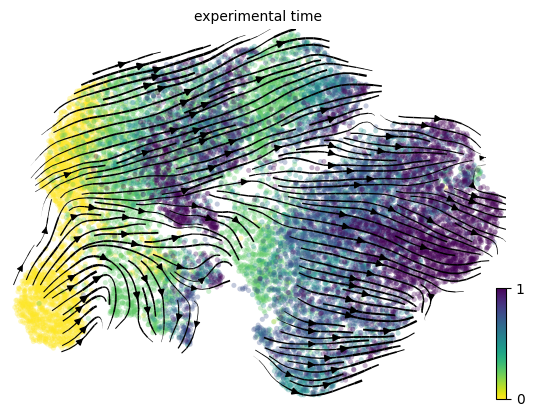

In [130]:
scv.pl.velocity_embedding_stream(adata_latent, vkey="T_fwd", basis="umap", color="experimental_time")

**Propagate with neural ODE**

In [131]:
node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

# Append first time point
trajs = []
with torch.no_grad():
    X_pf = torch.from_numpy(X[0])
    trajs.append(X_pf.unsqueeze(0))
    for t in range(n_times-1):
        traj = node.trajectory(X_pf.float().to(device),
            t_span=torch.linspace(t, t+1, 400),
        ).cpu()
        X_pf = traj[-1]
        trajs.append(X_pf.unsqueeze(0))

trajs = torch.cat(trajs, dim=0)

In [132]:
X_pf.shape

torch.Size([2613, 10])

In [133]:
X_pf = trajs.view(trajs.shape[0]*trajs.shape[1], -1)
times = torch.arange(5).unsqueeze(1).expand(trajs.shape[0],trajs.shape[1]).ravel()
times = pd.DataFrame(times)
times.columns = ["experimental_time"]

In [134]:
times.shape

(13065, 1)

In [135]:
adata_pf = sc.AnnData(X=X_pf.cpu().numpy(), 
                     obs=times)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

In [ ]:
sc.pl.umap(adata_pf, color="experimental_time")

Co-embed

In [ ]:
X_total = np.concatenate([adata_latent.X, X_pf], axis=0)
dataset_type = ["True" for _ in range(adata_latent.X.shape[0])] + \
                ["False" for _ in range(X_pf.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["Dataset_type"]

In [ ]:
adata_pf = sc.AnnData(X=X_total, 
                     obs=dataset_type)

In [ ]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

In [ ]:
sc.pl.umap(adata_pf, color="Dataset_type")